In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
train = tfds.load("malaria", as_supervised=True, data_dir="data\\",split="train[:80%]")
test = tfds.load("malaria", as_supervised=True, data_dir="data\\",split="train[80%:]")
max_x = max_y = max_z = 0
min_x = min_y = min_z = 400

train2 = tfds.load("malaria", as_supervised=True, data_dir="data\\",split="train[:80%]")
for i in train2:
    # print(i)
    for j in i:
        if j.dtype==tf.uint8:
            (x, y, z) = j.shape
            max_x = max(x,max_x)
            max_y = max(y,max_y)
            max_z = max(z,max_z)

            min_x = min(x,min_x)
            min_y = min(y,min_y)
            min_z = min(z,min_z)
print(max_x, max_y, max_z, min_x, min_y, min_z)

385 394 3 40 46 3


Alright, we need first a feature extractor then a classifier

What are the classes that we are looking for? It's infected and non-infected. 

Our first attempt will be to go minimalistic: After all, it's most resource-efificent to go with the least complexity necessary.

This means:
* Input
* One convolution layer
* Pool
* Classifier (output)

One issue we are facing is that the dataset images are of very different sizes. This will require padding!
Which type of padding do we want to use? The differences in dimensions are staggering!
It would be a good idea to print some of the images, especially large and small ones, to see how padding would affect them.

Options are:
* Crop to quadratic shape
* Resize and fill the empty space with zeroes
* resize and stretch the image

<Figure size 576x576 with 0 Axes>

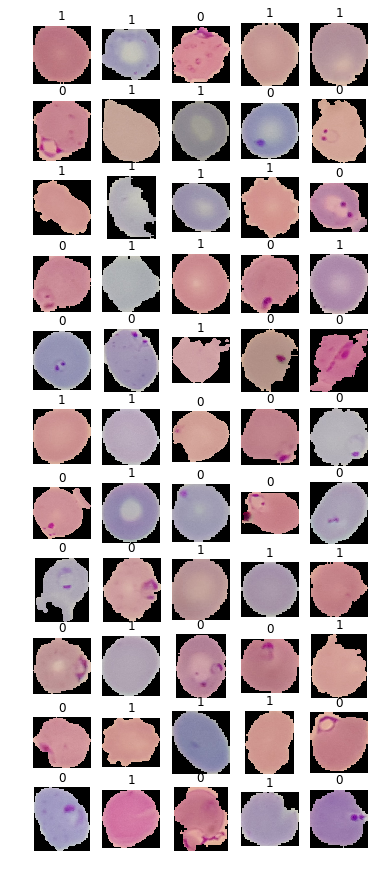

In [3]:
def tile_plot(train,imgs=55,greyscale=False,scale=False):
    fig = plt.figure(figsize=(8,8))
    columns = 4
    rows = 10
    fig, ax = plt.subplots(1,imgs)
    for i,j in enumerate(train):
        img= j[0]
        lbl = j[1].numpy()
        subax = fig.add_subplot(rows+1,columns+1,i+1)   
        subax.axis("off")
        subax.set_title(lbl)

        if greyscale:
            if scale:
                plt.imshow(np.squeeze(img),vmin=-2, vmax= 2.5,cmap="gray")
            else:
                plt.imshow(tf.cast(np.squeeze(img),tf.uint8),cmap="gray")
        else:
            plt.imshow(tf.cast(img,tf.uint8))
        # ax[i].set_title(lbl)
        ax[i].axis("off")
        if i == (imgs-1): #this is really awkward, but sadly prefetch_datasets are quite particular about indexing
            break
    plt.subplots_adjust(top=3)
    plt.show()

tile_plot(train)
# tile_plot(train,greyscale=True,scale=True)

It appears as though the images are already zero-padded anyways, so my first instinct would be to apply zero padding. This also makes sense because it preserves the information of cell size, which might be interesting to have.

In [4]:
train = tfds.load("malaria", as_supervised=True, data_dir="data\\",split="train[:80%]")
test = tfds.load("malaria", as_supervised=True, data_dir="data\\",split="train[80%:]")

target_height = 400
target_width = 400

train = train.map(lambda x,y : (tf.image.resize_with_pad(x, target_height, target_width, method=tf.image.ResizeMethod.LANCZOS3, antialias=False), tf.reshape(tf.one_hot(y, 2), (-1,) )))
test = test.map(lambda x,y : (tf.image.resize_with_pad(x, target_height, target_width, method=tf.image.ResizeMethod.LANCZOS3, antialias=False), tf.reshape(tf.one_hot(y, 2), (-1,) )))

<Figure size 576x576 with 0 Axes>

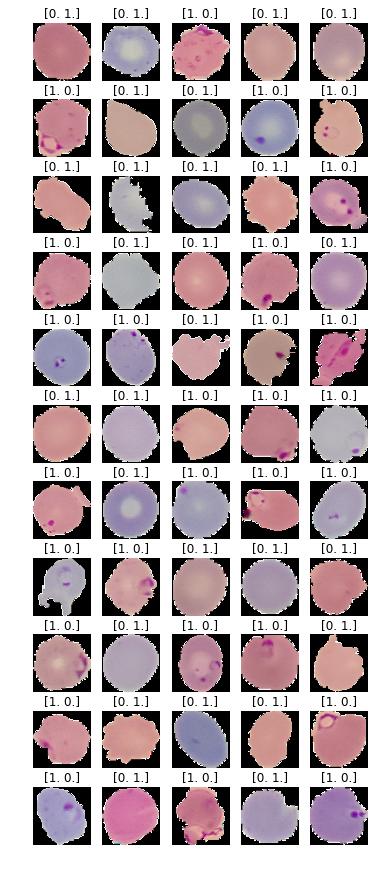

In [5]:
tile_plot(train)

<Figure size 576x576 with 0 Axes>

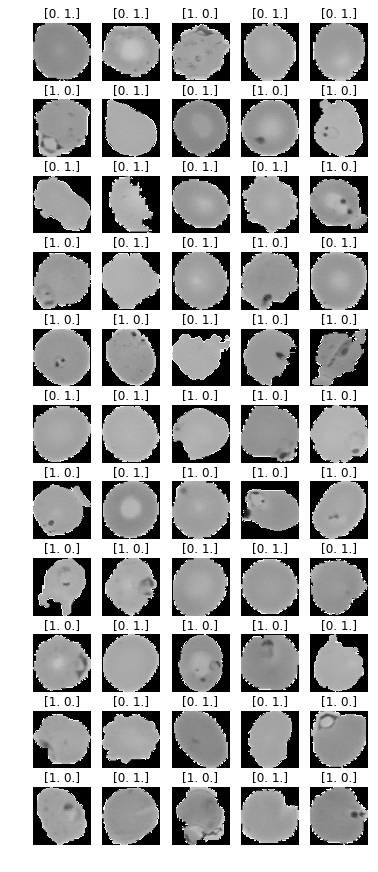

In [6]:
train = train.map(lambda x,y  : (tf.image.rgb_to_grayscale(x), y) )
tile_plot(train,greyscale=True)

In [7]:
#normalize the data
train = train.map(lambda x,y: (tf.image.per_image_standardization(
    x), y))
test = test.map(lambda x,y: (tf.image.per_image_standardization(
    x), y))

<Figure size 576x576 with 0 Axes>

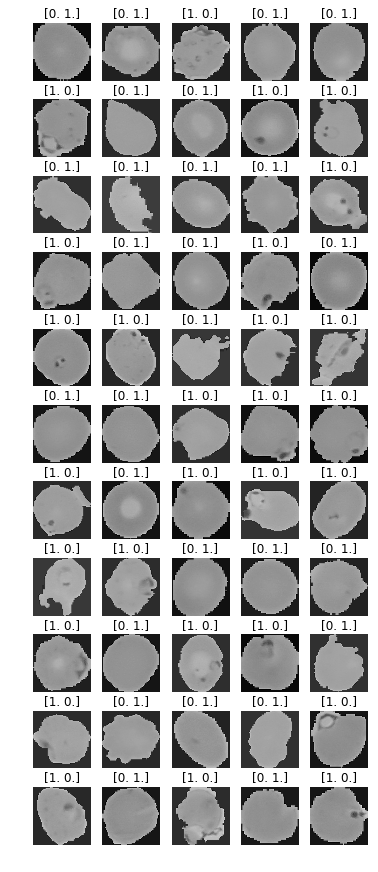

In [8]:
tile_plot(train,greyscale=True,scale=True)

In [18]:
train = train.batch(64).shuffle(buffer_size=64).prefetch(16)
test = test.batch(64).shuffle(buffer_size=64).prefetch(16)

In [16]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the 9 layers, alternating between convolutional(relu) and pooling layers, ending with global
        # average pooling and an softmax output layer
        self.conv_layer_1= tf.keras.layers.Conv2D(filters= 25, kernel_size= 3, strides=(1, 1), padding='valid',  activation=tf.keras.activations.relu, input_shape = (64,70,70,3))

        self.pool_layer_2= tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid')

        self.conv_layer_3= tf.keras.layers.Conv2D(filters= 25, kernel_size= 3, strides=(1, 1), padding='valid',  activation=tf.keras.activations.relu)

        self.pool_layer_4= tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid')

        self.conv_layer_5= tf.keras.layers.Conv2D(filters= 25, kernel_size= 3, strides=(1, 1), padding='valid',  activation=tf.keras.activations.relu)

        self.pool_layer_6= tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='valid')

        self.conv_layer_7= tf.keras.layers.Conv2D(filters= 25, kernel_size= 3, strides=(1, 1), padding='valid',  activation=tf.keras.activations.relu)

        self.global_pooling_layer_8 = tf.keras.layers.GlobalAveragePooling2D()

        self.output_layer_10 = tf.keras.layers.Dense(units=2, activation=tf.keras.activations.softmax)

    #propagates the input through the network
    #tf.function decorator models function as a graph
    @tf.function 
    def call(self, x):
        # Define the forward step.
        x = self.conv_layer_1(x)
        x = self.pool_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.pool_layer_4(x)
        x = self.conv_layer_5(x)
        x = self.pool_layer_6(x)
        x = self.conv_layer_7(x)
        x = self.global_pooling_layer_8(x)
        x = self.output_layer_10(x)
        return x

In [13]:
def train_step(model, data, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(data)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test_step(model, test, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (data, target) in test:
    prediction = model(data)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)

    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [17]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 2
learning_rate = 0.0001
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test_step(model, test, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test_step(model, train, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train = train.shuffle(buffer_size=128)
    test = test.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (data,target) in train:
        train_loss = train_step(model, data, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test_step(model, test, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

ResourceExhaustedError: Failed to allocate memory for the batch of component 0

In [ ]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()